## Discrete Data + Probability Exercises

- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

### Wrangle

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

In [4]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [5]:
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [6]:
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [7]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [8]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
24.26.242.9,21,0.001502


From here we can find how many unique ip addresses there are:

<AxesSubplot:>

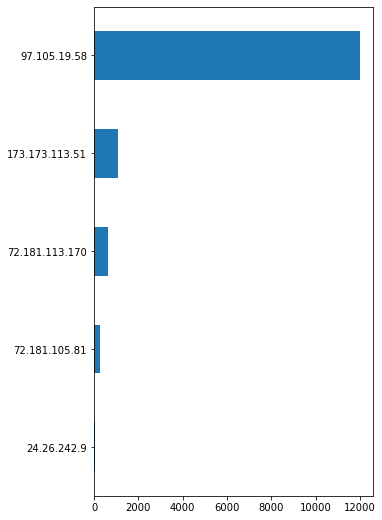

In [9]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

### Conditional Probabilities

In [10]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


### Look for Other Anomalies

In [13]:
status_code_df = value_counts_and_frequencies(df.status_code)
status_code_df.head()

,count,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


In [16]:
#Take a look at columns in df to see what we could look at for anomalous activity
df.columns

Index(['ip', 'request_method', 'request_path', 'http_version', 'status_code',
       'size', 'user_agent', 'size_mb'],
      dtype='object')

In [19]:
http_version_df = value_counts_and_frequencies(df.http_version)
http_version_df.head()

,count,proba
HTTP/1.1,13978,1.0


In [22]:
request_method_df = value_counts_and_frequencies(df.request_method)
request_method_df.head()

,count,proba
GET,13978,1.0


In [20]:
request_path_df = value_counts_and_frequencies(df.request_path)
request_path_df.head()

,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590


In [18]:
user_agent_df = value_counts_and_frequencies(df.user_agent)
user_agent_df.head()

,count,proba
python-requests/2.21.0,12005,0.858850
python-requests/2.20.1,1911,0.136715
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002432
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501


In [26]:
status_given_user_agent = (
    df.groupby('user_agent')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_user_agent')
    .reset_index()
)
status_given_user_agent.head()

,user_agent,status_code,proba_status_given_user_agent
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,200,1.0
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.0
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.0
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,200,1.0
4,Python-urllib/3.7,200,1.0


In [33]:
status_given_user_agent = (
    df.groupby('user_agent')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_user_agent')
    .reset_index()
)
status_given_user_agent[status_given_user_agent.user_agent == 'Slackbot 1.0 (+https://api.slack.com/robots)']

,user_agent,ip,proba_status_given_user_agent
7,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,0.166667
8,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,0.166667
9,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,0.166667
10,Slackbot 1.0 (+https://api.slack.com/robots),52.87.230.102,0.166667
11,Slackbot 1.0 (+https://api.slack.com/robots),52.90.165.200,0.166667
12,Slackbot 1.0 (+https://api.slack.com/robots),54.145.52.184,0.166667


In [35]:
status_given_user_agent = (
    df.groupby('user_agent')
    .ip.value_counts(normalize=True)
    .rename('proba_status_given_user_agent')
    .reset_index()
)
status_given_user_agent[status_given_user_agent.user_agent == 'Slackbot 1.0 (+https://api.slack.com/robots)']

,user_agent,ip,proba_status_given_user_agent
7,Slackbot 1.0 (+https://api.slack.com/robots),34.207.64.242,0.166667
8,Slackbot 1.0 (+https://api.slack.com/robots),34.229.70.250,0.166667
9,Slackbot 1.0 (+https://api.slack.com/robots),35.174.209.2,0.166667
10,Slackbot 1.0 (+https://api.slack.com/robots),52.87.230.102,0.166667
11,Slackbot 1.0 (+https://api.slack.com/robots),52.90.165.200,0.166667
12,Slackbot 1.0 (+https://api.slack.com/robots),54.145.52.184,0.166667


In [39]:
df[df.user_agent == 'Slackbot 1.0 (+https://api.slack.com/robots)']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 19:40:33,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 19:40:37,34.229.70.250,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 21:22:22,54.145.52.184,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 21:38:57,35.174.209.2,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-17 02:14:28,52.87.230.102,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154


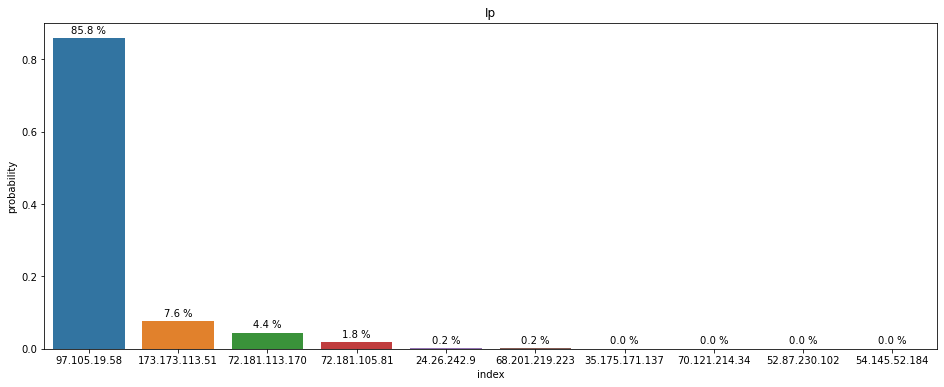

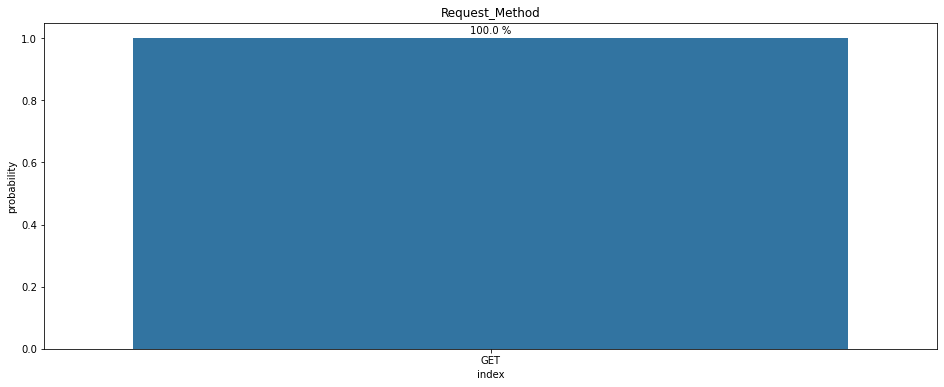

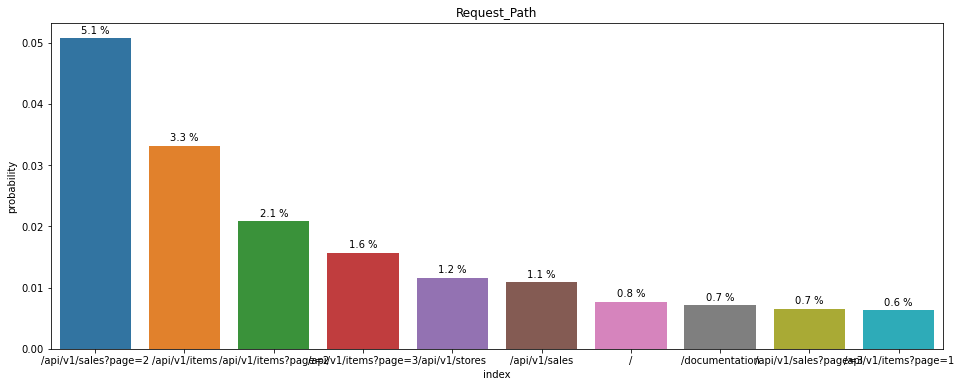

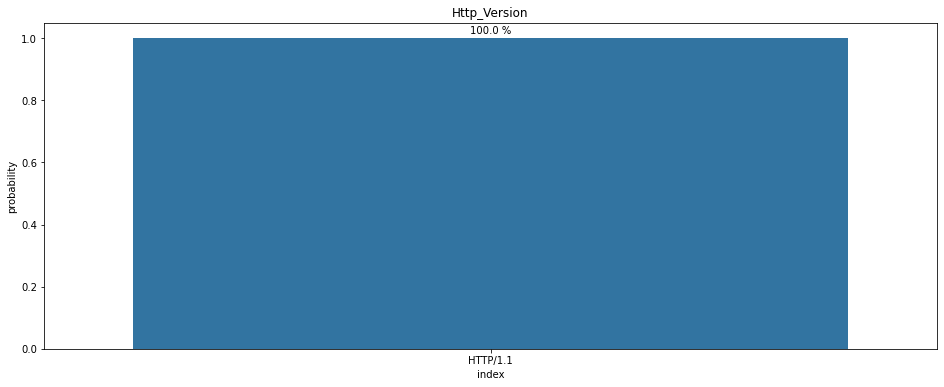

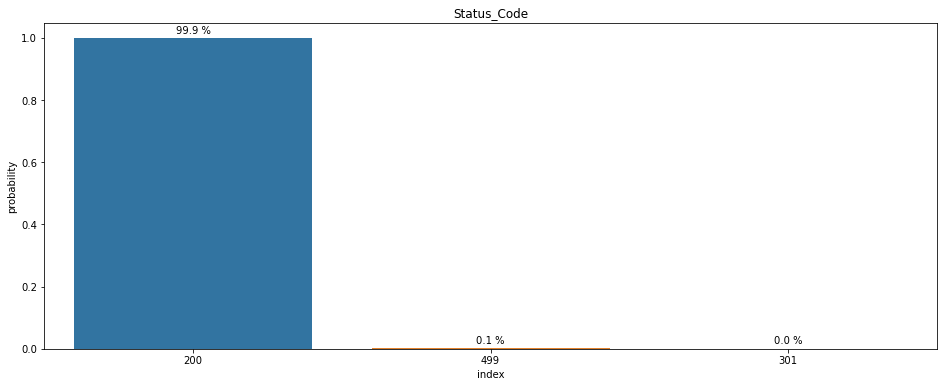

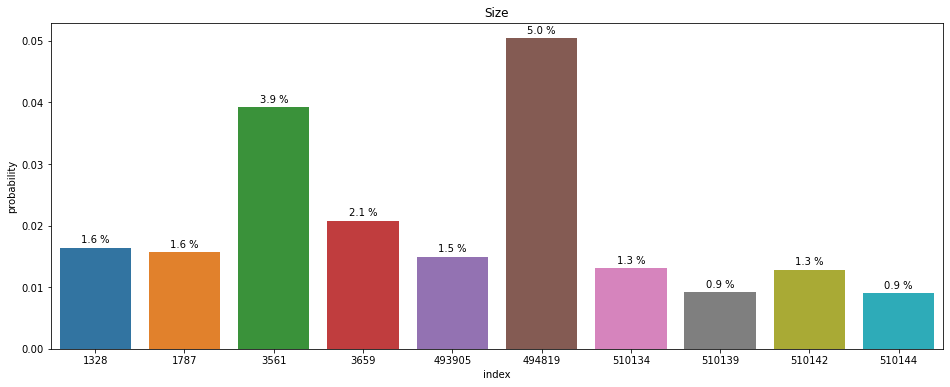

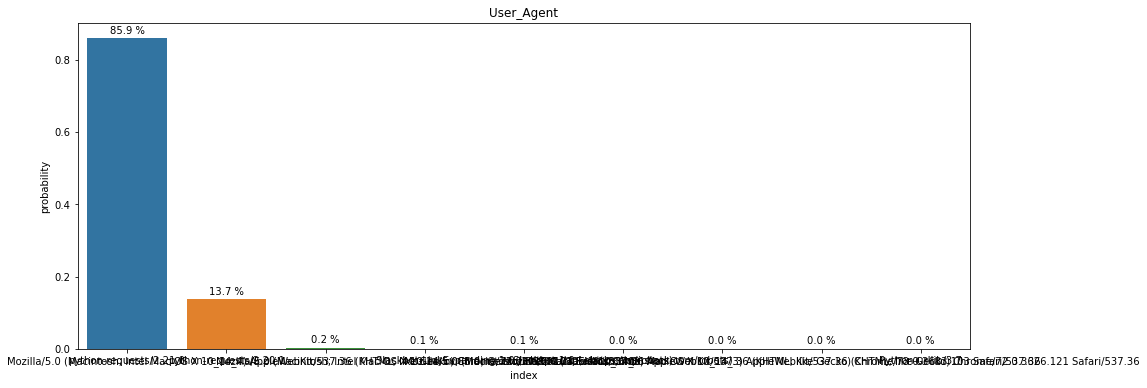

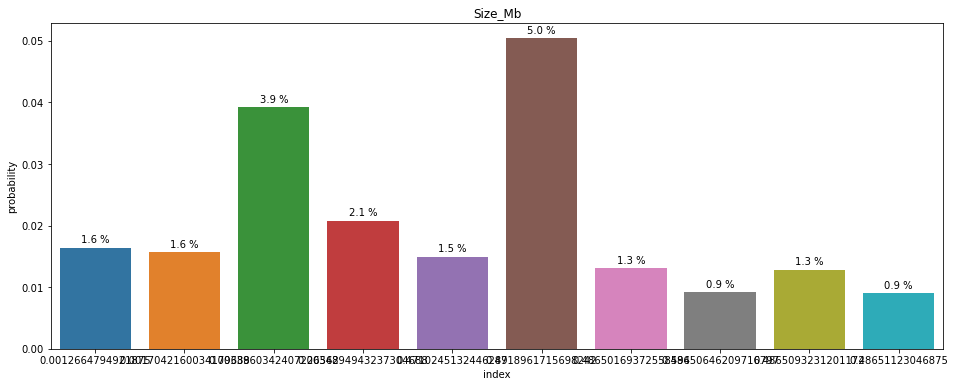

In [28]:
for col in df.columns:
    plt.figure(figsize=(16, 6))
    splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

In [44]:
timestamp_df = value_counts_and_frequencies(df.index)
timestamp_df.head()

,count,proba
2019-04-16 19:56:10,9,0.000644
2019-04-16 19:49:58,8,0.000572
2019-04-16 20:01:30,7,0.000501
2019-04-16 20:12:23,6,0.000429
2019-04-16 20:52:17,6,0.000429


In [47]:
df[df.user_agent == 'Slackbot 1.0 (+https://api.slack.com/robots)']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 19:40:33,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 19:40:37,34.229.70.250,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 21:22:22,54.145.52.184,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-16 21:38:57,35.174.209.2,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154
2019-04-17 02:14:28,52.87.230.102,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154


In [48]:
df[df.user_agent =='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 01:25:07,72.181.105.81,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000040
2019-04-17 01:25:21,72.181.105.81,GET,/documentation,HTTP/1.1,200,348,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000332
2019-04-17 01:33:06,72.181.105.81,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.003489
2019-04-17 01:33:19,72.181.105.81,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001704
2019-04-17 01:33:32,72.181.105.81,GET,/api/v1/items?page=4,HTTP/1.1,200,48,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000046
2019-04-17 01:56:33,72.181.105.81,GET,/api/v1/stores,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001266
2019-04-17 01:56:57,72.181.105.81,GET,/api/v1/sales,HTTP/1.1,200,493905,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025
2019-04-17 02:07:44,72.181.105.81,GET,/api/v1/sales,HTTP/1.1,200,493905,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025


<Figure size 432x288 with 0 Axes>

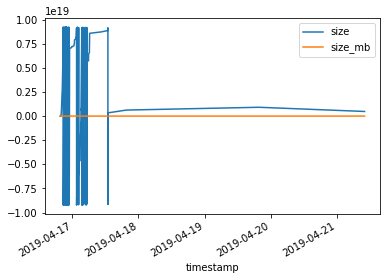

<Figure size 432x288 with 0 Axes>

In [57]:

status_given_user_agent= status_given_user_agent.cumsum()

plt.figure();

status_given_user_agent.plot();


df= df.cumsum()

plt.figure();

